In [1]:
import json
import subprocess
keys = json.loads(subprocess.run(["sops", "decrypt", "API_keys.enc.json"], capture_output=True).stdout)

# [LangChain](https://docs.langchain.com/docs/)

In [2]:
import langchain
langchain.__version__

'0.3.26'

## [Components](https://python.langchain.com/docs/how_to/) are the core building blocks you can use when building applications:

### Prompt templates

Prompt Templates are responsible for formatting user input into a format that can be passed to a language model.

### Example selectors

Example Selectors are responsible for selecting the correct few shot examples to pass to the prompt.

### Chat models

Chat Models are newer forms of language models that take messages in and output a message (taking care of special tokens).
> message in ➡️ message out

### Messages

Messages are the input and output of chat models. They have some content and a role, which describes the source of the message.

### LLMs

What LangChain calls LLMs are older forms of language models that take a string in and output a string.
> text in ➡️ text out

### Output parsers

Output Parsers are responsible for taking the output of an LLM and parsing into more structured format (e.g. prompt instructions + string parsing, Pydantic models...).

### Document loaders

Document Loaders are responsible for loading documents from a variety of sources.

### Text splitters

Text Splitters take a document and split into chunks that can be used for retrieval.
> documents in ➡️ chunks out

### Embedding models

Embedding Models take a piece of text and create a numerical representation of it. 
> text in ➡️ vector out

### Vector stores

  - [Pinecone](https://www.pinecone.io/)
  - [Weaviate](https://weaviate.io/)
  - [Chroma](https://www.trychroma.com/)
  - [FAISS](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/)

Vector Stores are databases that can efficiently store and retrieve embeddings.

### Retrievers

Retrievers are responsible for taking a query and returning relevant documents.

### Tools

LangChain Tools contain a description of the tool (to pass to the language model) as well as the implementation of the function to call. 

### ⛓️ Chains

One point about LangChain Expression Language is that any two runnables can be "chained" together into sequences. The output of the previous runnable's ```.invoke()``` call is passed as input to the next runnable. This can be done using the pipe operator ( **|** ).

### 🤖 Agents

By themselves, language models can't take actions - they just output text. A big use case for LangChain is creating agents. Agents are systems that use LLMs as reasoning engines to determine which actions to take and the inputs necessary to perform the action. After executing actions, the results can be fed back into the LLM to determine whether more actions are needed, or whether it is okay to finish.

## Usage

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(openai_api_key=keys['OpenAI']) #, temperature=.7)

In [4]:
print( llm.invoke("In less than 100 words, tell me more about the Gen AI framework landscape.").content )

The Gen AI framework landscape encompasses a diverse range of tools, platforms, and technologies designed to enable the development of artificial intelligence systems that can adapt, evolve, and learn like humans. These frameworks often leverage advanced machine learning algorithms, deep learning techniques, and neural networks to simulate human-like cognitive abilities such as reasoning, problem-solving, and decision-making. Some popular Gen AI frameworks include TensorFlow, PyTorch, and Keras, which provide developers with the tools and resources needed to create intelligent systems that can perform complex tasks and continuously improve over time. This dynamic and rapidly evolving field is driving innovation in various industries, from healthcare to finance to entertainment.


### Few-shot prompting

In [5]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain_ollama import ChatOllama

In [6]:
chat_openai = ChatOpenAI(openai_api_key=keys['OpenAI'])
chat_ollama = ChatOllama(model="llama3.2")

In [7]:
from langchain.prompts.example_selector import SemanticSimilarityExampleSelector
from langchain.prompts import PromptTemplate, FewShotPromptTemplate
from langchain_ollama import OllamaEmbeddings
from langchain.vectorstores import Chroma

In [8]:
example_prompt = PromptTemplate(
    input_variables=["input", "output"],
    template="Example Input: {input}\nExample Output: {output}",
)

examples = [
    {"input": "blue", "output": "sky"},
    {"input": "green", "output": "grass"},
    {"input": "red", "output": "tomato"},
    {"input": "orange", "output": "basketball"},
    {"input": "yellow", "output": "banana"},
]

In [9]:
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, 
    OllamaEmbeddings(model="nomic-embed-text"),
    Chroma, 
    k=2
)

In [10]:
similar_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix="Find an object that often matches the provided color.",
    suffix="Input: {noun}\nOutput:",
    input_variables=["noun"],
)

In [11]:
my_noun = "purple"
print(similar_prompt.format(noun=my_noun))

Find an object that often matches the provided color.

Example Input: blue
Example Output: sky

Example Input: orange
Example Output: basketball

Input: purple
Output:


In [12]:
print (chat_openai.invoke(similar_prompt.format(noun=my_noun)).content)

lavender


In [13]:
print (chat_ollama.invoke(similar_prompt.format(noun=my_noun)).content)

Lambs


### Structured Output

In [14]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser

response_schemas = [
    ResponseSchema(name="good_string", description="This is your response, a reformatted response.")
]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()

print (format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"good_string": string  // This is your response, a reformatted response.
}
```


In [15]:
template = """
You will be given a poorly formatted string from a user.
Reformat it and make sure all the words are spelled correctly

{format_instructions}

% USER INPUT:
{user_input}

YOUR RESPONSE:
"""

prompt = PromptTemplate(
    input_variables=["user_input"],
    partial_variables={"format_instructions": format_instructions},
    template=template
)

In [16]:
chat_ollama = ChatOllama(model="llama3.2")
chain = prompt | chat_ollama | output_parser

In [17]:
print (chain.invoke({"user_input": "welcom to califonya!"}))

{'good_string': 'Welcome to California!'}


### Configurable Fields

In [18]:
from langchain_core.runnables import ConfigurableField
model = ChatOpenAI(openai_api_key=keys['OpenAI'], max_tokens=20).configurable_fields(
    max_tokens=ConfigurableField(
        id="output_token_number",
        name="Max tokens in the output",
        description="The maximum number of tokens in the output",
    )
)

# max_tokens = 20
print(
    "max_tokens_20: ",
    model.invoke("tell me something about chess").content
)

# max_tokens = 200
print("max_tokens_200: ", model.with_config(
    configurable={"output_token_number": 200}
    ).invoke("tell me something about chess").content
)


max_tokens_20:  Chess is a strategic board game that has been played for centuries. It is believed to have originated in
max_tokens_200:  Chess is a strategic board game that has been played for centuries. It is believed to have originated in India during the 6th century and has since spread to become a popular game played worldwide. The objective of the game is to checkmate the opponent's king, which means putting the king in a position where it cannot escape capture. Chess is played on an 8x8 board with 16 pieces for each player, including pawns, rooks, knights, bishops, a queen, and a king. It is a game of skill, strategy, and foresight, requiring players to anticipate their opponent's moves and plan several steps ahead. Chess is often used as a tool to improve critical thinking, problem-solving, and decision-making skills.


### Chain

In [19]:
from langchain_core.output_parsers import StrOutputParser
chat_ollama = ChatOllama(model="llama3.2")

In [20]:
template = """Your role is to return a dish typical of the location (city or region) chosen by the user. Return the name of the dish only and nothing else.  
Location: {location}
Dish: 
"""
part1 = PromptTemplate(input_variables=["location"], template=template) | chat_ollama | StrOutputParser()

In [21]:
template = """Given a dish, give a short and simple recipe on how to make that dish at home.
Dish: {dish}
Recipe: 
"""
part2 = PromptTemplate(input_variables=["dish"], template=template) | chat_ollama | StrOutputParser()

In [22]:
from langchain.schema.runnable import RunnablePassthrough
chain = (
    {"dish": part1} 
    | RunnablePassthrough.assign(recipe=part2)
)

In [23]:
result = chain.invoke({"location": "Munich, Germany"})

In [24]:
import textwrap
wrap_width = 80
print("Output:\n_____")
for key, value in result.items():
    print(f"{key.capitalize()}:")
    paragraphs = value.split('\n\n')
    for paragraph in paragraphs:
        wrapped_paragraph = textwrap.fill(paragraph, width=wrap_width)
        print(wrapped_paragraph)
        print()

Output:
_____
Dish:
Weisswurst

Recipe:
Weisswurst is a traditional German dish! Here's a simplified recipe to make
Weisswurst at home:

Ingredients:

* 1 lb (450g) veal sausage meat (or pork sausage meat as a substitute) * 2 eggs
* 1/4 cup (60ml) milk * 1 tsp (5g) salt * 1/4 tsp (1.25g) white pepper * 1 tbsp
(15g) butter, melted * Weisswurst seasoning mix (or use a combination of nutmeg,
cardamom, and coriander) * Pretzel rods or soft pretzels for serving

Instructions:

1. In a large bowl, combine the sausage meat, eggs, milk, salt, white pepper,
and melted butter. Mix well with your hands until just combined. 2. Cover the
mixture and refrigerate for at least 30 minutes to allow the flavors to meld. 3.
Using a sausage stuffer or a piping bag, fill natural casings (you can purchase
these at most butcher shops or online) with the meat mixture. Twist the filled
casings into individual Weisswurst sausages. 4. Cook the Weisswurst in simmering
water for 10-15 minutes, or until cooked throu

### Tools

In [25]:
import requests
from langchain_core.tools import tool

@tool
def convert(currency_in: str, currency_out: str, amount: float) -> float:
    """Convert an amount between two currencies.
    Args:
      currency_in (str): The current currency eg USD
      currency_out (str): The target currency eg EUR
      amount (float): The amount to convert.
    """
    url = 'https://v6.exchangerate-api.com/v6/%s/pair/%s/%s'%(keys['ExchangeRate'],currency_in,currency_out)
    response = requests.get(url)
    data = response.json()
    return json.dumps(float(amount)*data['conversion_rate'])

In [26]:
messages= [
    SystemMessage(content="You are an helpful AI bot specialized in converting currencies. You are able to use the given tool to make some api call."),
    HumanMessage(content="How much is $100 in euros?")
]

In [27]:
chat_ollama = ChatOllama(model="llama3.2")
chat_ollama_with_tools = chat_ollama.bind_tools([convert])
output = chat_ollama_with_tools.invoke(messages)
messages.append(output)

In [28]:
for tool in output.tool_calls:
    selected_tool = {"convert": convert}[tool["name"].lower()]
    resp = selected_tool.invoke(tool["args"])
    messages.append({"role": "tool", "content":resp, "tool_call_id": tool["id"]})

In [29]:
output = chat_ollama_with_tools.invoke(messages)
print (output.content)

The value of $100 is approximately €85.55.


### Agent

In [30]:
from langchain_community.utilities import SerpAPIWrapper
from langchain_google_community import GooglePlacesAPIWrapper

llm = ChatOpenAI(temperature=0, api_key=keys['OpenAI'])
search = SerpAPIWrapper(serpapi_api_key=keys['SerpApi'])
places = GooglePlacesAPIWrapper(gplaces_api_key=keys['GoogleMaps'])

In [31]:
from langchain_core.tools import tool

@tool
def SearchWeb(question):
    """Useful for when you need to answer questions about current events or the current state of the world. You should ask targeted questions. Do NOT use this tool if you already have enough information to answer the question or if you've already searched once."""
    return search.run(question)

In [32]:
@tool
def GooglePlaces(location):
    """Finds information about places. The input MUST include the location in the format 'query - location', for example: 'Italian restaurants - Rome, Italy' or 'coffee shops - Times Square, New York City, NY'. Do NOT rely on your current location; always specify the place."""
    return places.run(location)

In [33]:
tools = [SearchWeb, GooglePlaces]

In [34]:
from langgraph.prebuilt import create_react_agent
graph = create_react_agent(model=llm, tools=tools)

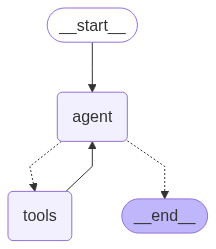

In [35]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [37]:
# Example query
question = "Where could I eat a nice pizza close to the Buttes Chaumont in Paris? (limited to 10 addresses sorted by reputation)"
inputs = {"messages": [("user", "%s"%question)]}

In [38]:
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Where could I eat a nice pizza close to the Buttes Chaumont in Paris? (limited to 10 addresses sorted by reputation)
================================== Ai Message ==================================
Tool Calls:
  GooglePlaces (call_mdDlfQJNwTHDC7J1rSLIGMzn)
 Call ID: call_mdDlfQJNwTHDC7J1rSLIGMzn
  Args:
    location: pizza restaurants - Buttes Chaumont, Paris
    limit: 10
    sort_by: reputation
================================= Tool Message =================================
Name: GooglePlaces

1. BOTZA - Paris 19
Address: 86 Rue Botzaris, 75019 Paris, France
Google place ID: ChIJZyteKvtt5kcRs2-itzAoD-w
Phone: 01 83 89 31 13
Website: http://botza.fr/


2. Casa di Marco Paris
Address: 50 Av. Simon Bolivar, 75019 Paris, France
Google place ID: ChIJ42dzeABt5kcRZEPw9aReTF4
Phone: 09 56 00 99 18
Website: https://casa-di-marco.com/


3. Da Paride
Address: 41 Av. Secrétan, 75019 Paris, France
Google place ID: C

## [LangSmith](https://smith.langchain.com)

https://eu.smith.langchain.com

In [39]:
import os

In [40]:
os.environ['LANGCHAIN_TRACING_V2']="true"
os.environ['LANGCHAIN_ENDPOINT']="https://eu.api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=keys['LangSmithEU']
os.environ['LANGCHAIN_PROJECT']="randomstate42"

In [41]:
from langsmith import utils
utils.tracing_is_enabled()

False

## LangGraph

At its core, LangGraph uses a directed graph structure to define the flow of your application:

1. **State**

State is the central concept in LangGraph. It represents all the information that flows through your application.

The state is User defined, hence the fields should carefully be crafted to contain all data needed for decision-making process!

2. **Nodes**

Nodes represent individual processing steps.

Nodes are *python functions*. 

Each node:

- Takes the state as input
- Performs some operation
- Returns updates to the state

For example, Nodes can contain:

- LLM calls: Generate text or make decisions
- Tool calls: Interact with external systems
- Conditional logic: Determine next steps
- Human intervention: Get input from users

3. **Edges**

Edges connect nodes and define the possible paths through your graph.

Edges can be:

- Direct: Always go from node A to node B
- Conditional: Choose the next node based on the current state

4. **StateGraph**

The StateGraph is the container that holds your entire agent workflow.

In [42]:
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END

In [43]:
os.environ["OPENAI_API_KEY"] = keys['OpenAI']
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [44]:
#Step 1: Define Our State

class EmailState(TypedDict):
    email: Dict[str, Any]           
    is_spam: Optional[bool]         
    spam_reason: Optional[str]      
    email_category: Optional[str]   
    draft_response: Optional[str]   
    messages: List[Dict[str, Any]]  

In [45]:
#  Step 2: Define Our Nodes

class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

# Define nodes
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}

def classify_email(state: EmailState):
    email = state["email"]
    
    prompt = f"""
As Alfred the butler of Mr wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr wayne's attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only reurn the answer
Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text
    
    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content}
        ]
    else :
        new_messages = state.get("messages", [])
    
    return {
        "is_spam": is_spam,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}

def drafting_response(state: EmailState):
    email = state["email"]
    
    prompt = f"""
As Alfred the butler, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """
    
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    return {
        "draft_response": response.content,
        "messages": new_messages
    }

def notify_mr_wayne(state: EmailState):
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")
    
    return {}

# Define routing logic
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [46]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email) # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email) # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam) #same logic 
email_graph.add_node("drafting_response", drafting_response) #same logic
email_graph.add_node("notify_mr_wayne", notify_mr_wayne) # same logic

In [47]:
# Step 3: Define Our Routing Logic

# Add edges
email_graph.add_edge(START, "read_email") # After starting we go to the "read_email" node

email_graph.add_edge("read_email", "classify_email") # after_reading we classify

# Add conditional edges
email_graph.add_conditional_edges(
    "classify_email", # after classify, we run the "route_email" function"
    route_email,
    {
        "spam": "handle_spam", # if it return "Spam", we go the "handle_span" node
        "legitimate": "drafting_response" # and if it's legitimate, we go to the "drafting response" node
    }
)

# Add final edges
email_graph.add_edge("handle_spam", END) # after handling spam we always end
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END) # after notifyinf Me wayne, we can end  too

In [48]:
# Compile the graph
compiled_graph = email_graph.compile()

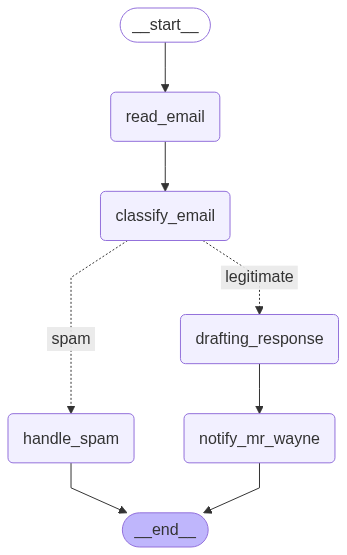

In [49]:
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [50]:
# Example emails for testing
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "draft_response": None,
    "messages": []
}) 


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Found you Batman!

Dear Mr. Joker,

Thank you for reaching out. Your message has been received and noted. Mr. Wayne values privacy and discretion, and any matters of concern will be addressed with the utmost seriousness.

Kind regards,

Alfred Pennyworth  
On behalf of Bruce Wayne


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email has been moved to the spam folder.


## LangFuse

In [51]:
# Get keys for your project from the project settings page: https://cloud.langfuse.com
LANGFUSE_PUBLIC_KEY="pk-lf-1f1b4ddb-8e93-43e9-8dae-c9512da60adf"
LANGFUSE_SECRET_KEY=keys['Langfuse']
os.environ["LANGFUSE_PUBLIC_KEY"] = LANGFUSE_PUBLIC_KEY
os.environ["LANGFUSE_SECRET_KEY"] = LANGFUSE_SECRET_KEY
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # 🇪🇺 EU region
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

# Process legitimate email
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None, "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Your Recent Correspondence

Dear Mr. Joker,

Thank you for reaching out. Your message has been received and noted. Mr. Wayne values privacy and discretion, and he will review your claims in due course. 

Kind regards,

Alfred Pennyworth  
Wayne Manor Estate



# [Hugging Face](https://huggingface.co/)

In [52]:
def convert_to_markdown(content):
    markdown = content.replace("\\(", "$").replace("\\)", "$")
    markdown = markdown.replace("\\[", "$$").replace("\\]", "$$")
    markdown = markdown.replace("\\,", " ")  # optional LaTeX cleanup
    return markdown

## using LangChain

In [53]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

In [54]:
model = "Qwen/Qwen2.5-Coder-32B-Instruct"
provider = 'together'

In [55]:
question = "How do you compute the integral of x between 1 and 2"

template = """Question: {question}

Answer: Let's think step by step."""

prompt = PromptTemplate.from_template(template)

llm = HuggingFaceEndpoint(
    repo_id=model,
    provider=provider, # mandatory as of mid-april 2025
    task="text-generation",
    max_new_tokens=1000,
    temperature=0.5,
    huggingfacehub_api_token=keys['HuggingFace']
)

chat_model = ChatHuggingFace(llm=llm)

In [56]:
llm_chain = prompt | chat_model
answer = llm_chain.invoke({"question": question})

In [57]:
# Assuming `response.content` contains the model output
markdown_output = convert_to_markdown(answer.content)

# Display in notebook
display(Markdown(markdown_output))

Certainly! To compute the integral of $ x $ from 1 to 2, we need to evaluate the definite integral:

$$
\int_{1}^{2} x   dx
$$

Here are the steps:

1. **Find the antiderivative of the integrand**: The integrand here is $ x $. The antiderivative of $ x $ is $ \frac{x^2}{2} $. This is because the derivative of $ \frac{x^2}{2} $ is $ x $.

2. **Apply the Fundamental Theorem of Calculus**: The Fundamental Theorem of Calculus states that if $ F(x) $ is an antiderivative of $ f(x) $, then:

$$
\int_{a}^{b} f(x)   dx = F(b) - F(a)
$$

In our case, $ f(x) = x $ and $ F(x) = \frac{x^2}{2} $. So, we need to evaluate $ F(x) $ at the upper limit (2) and subtract the value of $ F(x) $ at the lower limit (1).

3. **Evaluate the antiderivative at the limits of integration**:

$$
\int_{1}^{2} x   dx = \left[ \frac{x^2}{2} \right]_{1}^{2} = \frac{2^2}{2} - \frac{1^2}{2} = \frac{4}{2} - \frac{1}{2} = 2 - 0.5 = 1.5
$$

So, the integral of $ x $ from 1 to 2 is $ 1.5 $.

## using InferenceClient

In [58]:
from huggingface_hub import InferenceClient

client = InferenceClient(
    model = model,
    provider=provider,
	api_key=keys["HuggingFace"]
)

In [59]:
messages = [
	{
		"role": "user",
		"content": "How do you compute the integral of x between 2 and 3"
	}
]

In [60]:
completion = client.chat.completions.create(
	model=model,
	messages=messages, 
	max_tokens=500
)

In [61]:
# Assuming `response.content` contains the model output
markdown_output = convert_to_markdown(completion.choices[0].message.content)

# Display in notebook
display(Markdown(markdown_output))

To compute the definite integral of $ x $ from 2 to 3, you can follow these steps:

1. **Find the antiderivative of $ x $:**
   The antiderivative of $ x $ is $ \frac{x^2}{2} $. This is because the derivative of $ \frac{x^2}{2} $ is $ x $.

2. **Evaluate the antiderivative at the upper and lower limits of integration:**
   - At the upper limit (3):
     $$
     \left. \frac{x^2}{2} \right|_{x=3} = \frac{3^2}{2} = \frac{9}{2}
     $$
   - At the lower limit (2):
     $$
     \left. \frac{x^2}{2} \right|_{x=2} = \frac{2^2}{2} = \frac{4}{2} = 2
     $$

3. **Subtract the value of the antiderivative at the lower limit from the value at the upper limit:**
   $$
   \int_{2}^{3} x   dx = \left[ \frac{x^2}{2} \right]_{2}^{3} = \frac{9}{2} - 2 = \frac{9}{2} - \frac{4}{2} = \frac{5}{2}
   $$

So, the integral of $ x $ from 2 to 3 is $ \frac{5}{2} $ or 2.5.